## APhys Group Meeting (3.12.25)

In [1]:
# imports
import os
from glob import glob
import json
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings; warnings.filterwarnings('ignore')

### CTD Transects

In [18]:
# Lake Zug bathymetry
bathy = xr.open_dataset('../../../../data/lake_zug/bathymetry/zugersee_bathy.nc')

In [25]:
# planned locations
profile_locs = pd.DataFrame({
    'loc': [f'P{x}' for x in range(1, 13)],
    'xsc': [679803, 679803, 679663, 679415, 679505, 680030, 680150, 680223, 680409, 680814, 681350, 681909],
    'ysc': [224100, 222690, 221650, 220433, 219544, 218872, 218462, 218126, 217437, 216239, 214957, 213760]
})

profile_locs['xsc'] += int(2e6)
profile_locs['ysc'] += int(1e6)

profile_locs['depth'] = [bathy.sel(xsc=row.xsc, ysc=row.ysc).depth.item() for _, row in profile_locs.iterrows()]

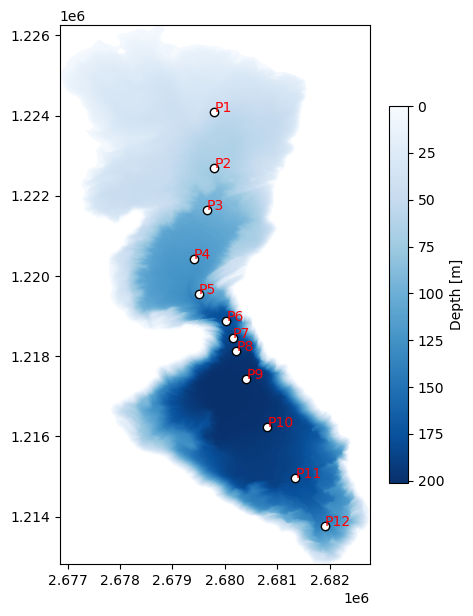

In [23]:
fig, ax = plt.subplots(figsize=(5, 7))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

# planned locations
for _, row in profile_locs.iterrows():
    ax.scatter(row.xsc, row.ysc, c='white', edgecolor='black')
    ax.annotate(row['loc'], (row.xsc, row.ysc), color='red')

plt.savefig('../../gallery/aphys/2025_12_03/ctd_locations.png', bbox_inches='tight')
plt.show()

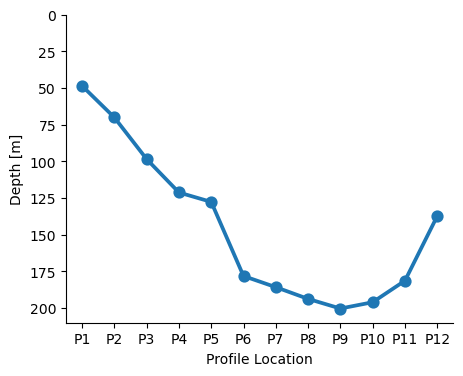

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))

sns.pointplot(profile_locs, x='loc', y='depth', ax=ax)

ax.set_xlabel('Profile Location')
ax.set_ylabel('Depth [m]')
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(0, 210)
ax.invert_yaxis()

plt.savefig('../../gallery/aphys/2025_12_03/ctd_depth.png', bbox_inches='tight')
plt.show()

In [7]:
root = 'Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2025/CTD'
date_dirs = ['20251030', '20251107', '20251114', '20251121']

In [8]:
def locate_files(root, date_dir):
    L0_dir = os.path.join(root, date_dir, 'L0')
    md_files = glob(f'{L0_dir}/*.meta', root_dir=root)
    profiles = glob(f'{L0_dir}/*.nc', root_dir=root) + glob(f'{L0_dir}/*.TOB', root_dir=root)

    return md_files, profiles

def parse_RBR(profile):
    ds = xr.open_dataset(profile)

    # select down cast
    bottom_idx = np.argmax(ds.pressure.values)
    ds = ds.isel(timestamp=slice(0, bottom_idx + 1))

    # remove air
    air_idx = np.where(ds.depth.values < 0)[0][-1]
    ds = ds.isel(timestamp=slice(air_idx + 1, None))

    return ds

def parse_sea_and_sun(profile):
    with open(profile, encoding='latin1', errors='ignore') as f:
            lines = f.readlines()

    for l in range(len(lines)):
        if "Lines :" in lines[l]:
            break

    columns = lines[l + 2].replace(";", "").split()[1:]
    df = pd.read_csv(profile, sep='\s+', header=None, skiprows=l+5, names=columns, engine='python', encoding='cp1252')

    # select downcast
    bottom_idx = np.argmax(df['Press'])
    df = df[:bottom_idx]

    # remove air
    df = df[df['Press'] > 0]

    return df

def parse_profiles(md_files, profiles):
    data = {}
    for md_file, profile in tqdm(zip(md_files, profiles)):
        with open(md_file, 'r') as f:
            md = json.load(f)

        location = md['profile']['Profile name']
        i = int(location[1:]) - 1
        date = md['campaign']['Date of measurement']

        _, ext = os.path.splitext(profile)
        # Sea and Sun
        if ext == '.TOB':
            df = parse_sea_and_sun(profile)

            data[i] = {
                'date': date,
                'location': location,
                'press': df['Press'].values,
                'temp': df['Temp'].values,
                'd_oxygen_conc': df['DO_mg'].values * (1000/32)
            }
        # RBR
        elif ext == '.nc':
            ds = parse_RBR(profile)

            data[i] = {
                'date': date,
                'location': location,
                'press': ds.pressure.values - ds.pressure.values.min(),
                'temp': ds.temperature.values,
                'd_oxygen_conc': ds.dissolved_o2_concentration.values
            }

    return data

In [9]:
all_data = []
for date_dir in date_dirs:
    md_files, profiles = locate_files(root, date_dir)
    data = parse_profiles(md_files, profiles)
    all_data.append(data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

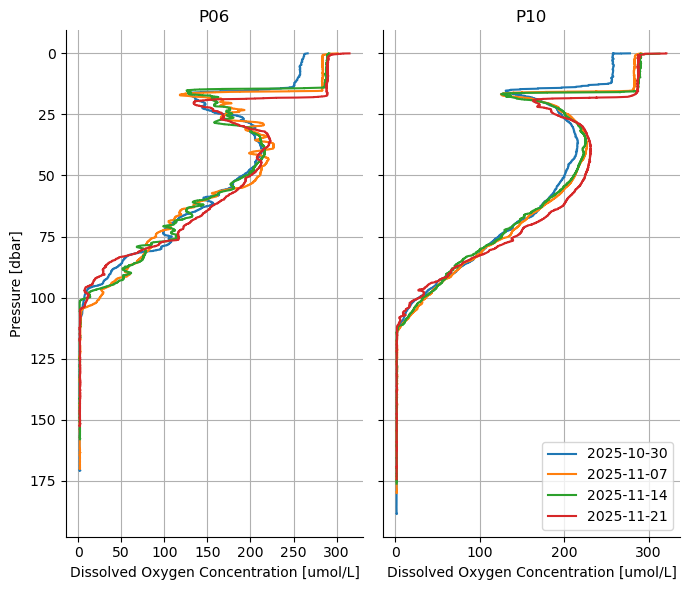

In [249]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 6), sharey=True)
for data in all_data:
    for i, dat in data.items():
        if i == 5:
            ax[0].plot(dat['d_oxygen_conc'], dat['press'], label=dat['date'])
            
            ax[0].set_title(dat['location'])
        elif i == 9:
            ax[1].plot(dat['d_oxygen_conc'], dat['press'], label=dat['date'])
            ax[1].set_title(dat['location'])

ax[0].set_xlabel('Dissolved Oxygen Concentration [umol/L]')
ax[0].set_ylabel('Pressure [dbar]')
ax[1].set_xlabel('Dissolved Oxygen Concentration [umol/L]')

ax[0].invert_yaxis()

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].grid(True)
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.savefig('../../gallery/aphys/2025_12_03/ctd_o2_CS.png', bbox_inches='tight')
plt.show()

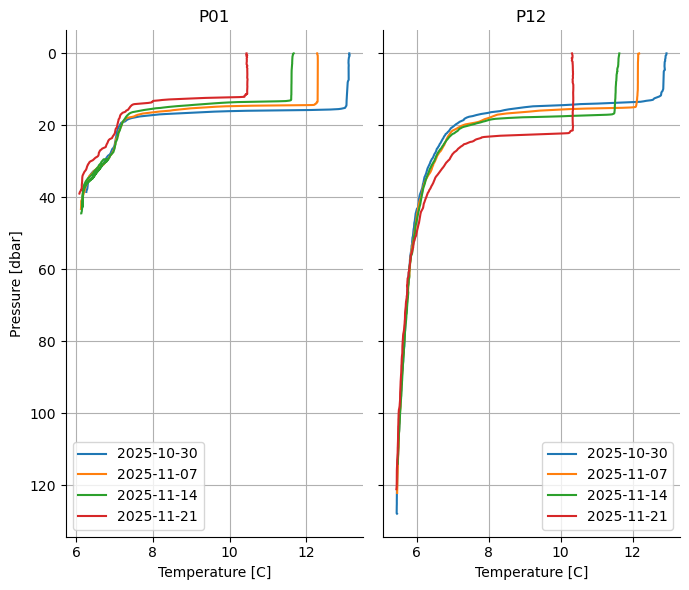

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 6), sharey=True)
for data in all_data:
    for i, dat in data.items():
        if i == 0:
            ax[0].plot(dat['temp'], dat['press'], label=dat['date'])
            
            ax[0].set_title(dat['location'])
        elif i == 11:
            ax[1].plot(dat['temp'], dat['press'], label=dat['date'])
            ax[1].set_title(dat['location'])

ax[0].set_xlabel('Temperature [C]')
ax[0].set_ylabel('Pressure [dbar]')
ax[1].set_xlabel('Temperature [C]')

ax[0].invert_yaxis()

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

### Moorings

In [168]:
mooring_locs = pd.DataFrame({
    'loc': ['LZC', 'LZE', 'LZW', 'LZN'],
    'xsc': [2680084, 2680314, 2679912, 2679436],
    'ysc': [1218840, 1218883, 1218760, 1219384]
})

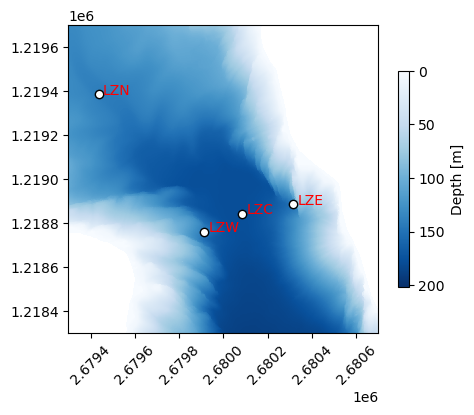

In [172]:
fig, ax = plt.subplots(figsize=(5, 4))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

for _, row in mooring_locs.iterrows():
    # deployed locations
    ax.scatter(row.xsc, row.ysc, c='white', edgecolor='black')
    ax.annotate(row['loc'], (row.xsc, row.ysc), color='red', xytext=(3, 0), textcoords='offset points')

ax.tick_params(axis='x', rotation=45)
ax.set_xlim(2679300, 2680700)
ax.set_ylim(1218300, 1219700)

plt.savefig('../../gallery/aphys/2025_12_03/mooring_locations.png', bbox_inches='tight')
plt.show()

### VMP

In [218]:
# add final day locations
vmp_locs = pd.DataFrame({
    'loc': [
        'VMPS', 'VMPS', 'VMPC', 'VMPC', 'VMPC', 
        'VMPS', 'VMPS', 'VMPC', 'VMPC', 'VMPC',
        'VMPC', 'VMPC', 'VMPC', 'VMPW', 'VMPW', 'VMPW', 'VMPW'
    ],
    'xsc': [
        680422, 680538, 680154, 680105, 680124,
        680335, 680482, 680086, 680119, 680119,
        680069, 680075, 680112, 679911, 679918, 679921, 679939
    ],
    'ysc': [
        216834, 216813, 218711, 218781, 218792,
        217000, 216713, 218780, 218776, 218778,
        218669, 218821, 218802, 218799, 218793, 218794, 218816
    ]
})

vmp_locs['xsc'] += int(2e6)
vmp_locs['ysc'] += int(1e6)

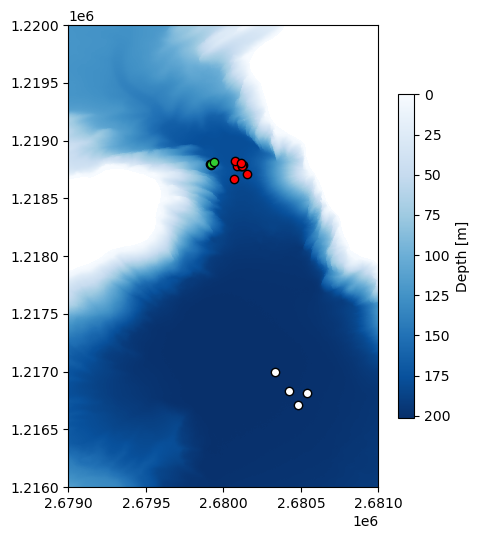

In [226]:
fig, ax = plt.subplots(figsize=(5, 6))

im = ax.pcolormesh(bathy['xsc'], bathy['ysc'], bathy['depth'], cmap='Blues', vmin=0)
cbar = fig.colorbar(im, shrink=0.7, label='Depth [m]', ax=ax)
cbar.ax.invert_yaxis()

# vmp locations
for _, row in vmp_locs.iterrows():
    if row['loc'] == 'VMPS':
        c = 'white'
    elif row['loc'] == 'VMPC':
        c = 'red'
    elif row['loc'] == 'VMPW':
        c = 'limegreen'

    ax.scatter(row.xsc, row.ysc, c=c, edgecolor='black')

ax.set_xlim(2679000, 2681000)
ax.set_ylim(1216000, 1220000)

plt.savefig('../../gallery/aphys/2025_12_03/vmp_locations.png', bbox_inches='tight')
plt.show()

### Water Age

In [175]:
df = pd.read_csv('../../../../data/lake_zug/water_samples/historical.csv')

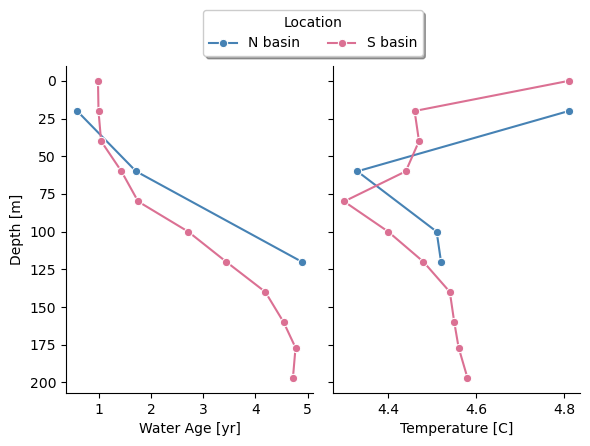

In [216]:
# compare N and S basin on same date
df_sel = df.query("date == '2.4.1992'")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), sharey=True)
loc_order = ['ZG3 (N basin)', 'ZG5 (deepest point)']
palette = ['steelblue', 'palevioletred']

sns.lineplot(df_sel, x='water_age', y='depth', orient='y', hue='location', 
             hue_order=loc_order, palette=palette, marker='o', ax=ax[0], legend=False)

sns.lineplot(df_sel, x='temperature', y='depth', orient='y', hue='location', 
             hue_order=loc_order, palette=palette, marker='o', ax=ax[1])


ax[0].set_xlabel('Water Age [yr]')
ax[0].set_ylabel('Depth [m]')
ax[1].set_xlabel('Temperature [C]')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].invert_yaxis()

labels = ['N basin', 'S basin']
handles, _ = ax[1].get_legend_handles_labels()
ax[1].get_legend().remove()
fig.legend(handles, labels, title='Location', ncols=2, shadow=True, loc='upper center', bbox_to_anchor=(0.53, 1.12))

plt.tight_layout()
plt.savefig('../../gallery/aphys/2025_12_03/water_age_NS.png', bbox_inches='tight')
plt.show()

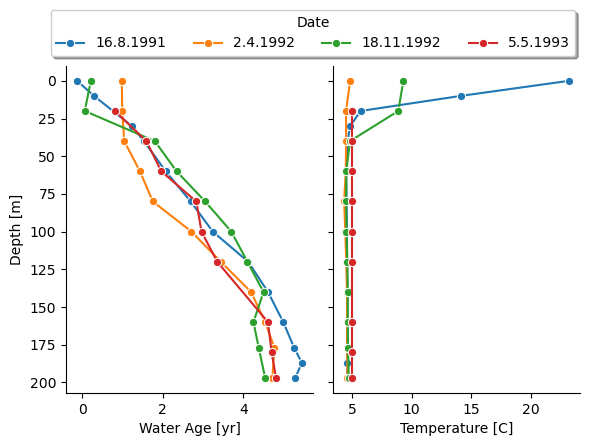

In [217]:
# compare S basin over time
df_sel = df.query("location == 'ZG5 (deepest point)'")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), sharey=True)
date_order = ['16.8.1991', '2.4.1992', '18.11.1992', '5.5.1993']

sns.lineplot(df_sel, x='water_age', y='depth', orient='y', hue='date', hue_order=date_order,
             palette='tab10', marker='o', ax=ax[0], legend=False)

sns.lineplot(df_sel, x='temperature', y='depth', orient='y', hue='date', hue_order=date_order,
             palette='tab10', marker='o', ax=ax[1])

ax[0].set_xlabel('Water Age [yr]')
ax[0].set_ylabel('Depth [m]')
ax[1].set_xlabel('Temperature [C]')

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)

ax[0].invert_yaxis()

handles, labels = ax[1].get_legend_handles_labels()
ax[1].get_legend().remove()
fig.legend(handles, labels, title='Date', ncols=4, shadow=True, loc='upper center', bbox_to_anchor=(0.53, 1.12))

plt.tight_layout()
plt.savefig('../../gallery/aphys/2025_12_03/water_age_S.png', bbox_inches='tight')
plt.show()